# Modelling of Physical Systems lab 6 - Stanisław Borowy

## Introduction

Following code is solution to advection problem using Monte Carlo method. It works by
modelling individual particles and simulating their movement through 2D space. Particles'
cell index or multiplicity (depending on whether they are sampled with constant multiplicity
or uniformly in x any y respectively) are derived from from multivariate, 2D normal
distribution.

In [1]:
"""Module docstring."""

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot

In [2]:
PARAMS_P = SimpleNamespace(
    n_part=1000,
    norm=1e10,
    dist=scipy.stats.multivariate_normal([250, 250], np.diag((350, 350))),
)

PARAMS_SPACE = SimpleNamespace(
    span=1000,
    n_cell=50,
)
PARAMS_SPACE.step = PARAMS_SPACE.span / PARAMS_SPACE.n_cell

RNG = np.random.default_rng(seed=44)

In [3]:
def sample(*, params_p, params_space, rng):
    """Sample particles in a 2D space."""

    u01 = rng.uniform([0.0, 0.0], [1.0, 1.0], size=(params_p.n_part, 2))

    return {
        k: {
            'cell': (v['cell'] / params_space.step).astype(int),
            'mult': np.round(v['mult'] * params_p.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x and y': {
                'cell': u01 * params_space.span,
                'mult': params_p.dist.pdf(u01 * params_space.span) \
                    * params_space.span ** 2 / params_p.n_part,
            },
            'sampling: constant multiplicity': {
                'cell': params_p.dist.rvs(params_p.n_part),
                'mult': np.ones(params_p.n_part) / params_p.n_part
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_space=PARAMS_SPACE, rng=RNG)

## Visualization

2D particles' space can be visualized using 2D histogram - a grid of cells, where brightness
of each cell represents weight of particles inside of it.

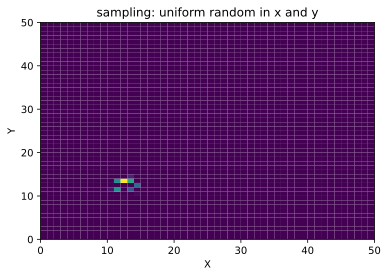

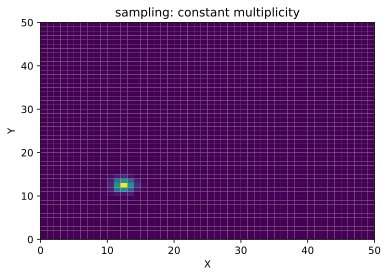

In [4]:
def plot(*, particles, params_space):
    """Plot the particles in 2D space."""
    for title, data in particles.items():
        pyplot.hist2d(
            x = data['cell'].T[0],
            y = data['cell'].T[1],
            bins=params_space.n_cell,
            weights=data['mult'],
            range=[[0, params_space.n_cell], [0, params_space.n_cell]],
            cmap='viridis',
        )
        pyplot.title(title)
        pyplot.xlabel('X')
        pyplot.ylabel('Y')
        show_plot()

plot(particles=PARTICLES, params_space=PARAMS_SPACE)

## Advection

Advection is conducted in similar way to 1D case. At each timestep, particle may randomly
move to cell above, to the right, or even to top-right.

In [5]:
PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 30,
    wind = 1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number = PARAMS_T.wind / PARAMS_SPACE.step * PARAMS_T.step

In [6]:
def advect(*, params_p, params_t, particles, rng):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift = abs(params_t.courant_number)
    assert probability_of_shift < 1

    for _ in range(params_t.n_step):
        u01 = rng.uniform([0.0, 0.0], [1.0, 1.0], (params_p.n_part, 2))
        for particle in particles.values():
            particle['cell'] += np.array(probability_of_shift > u01, dtype=int)

advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

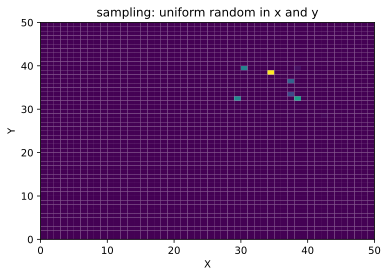

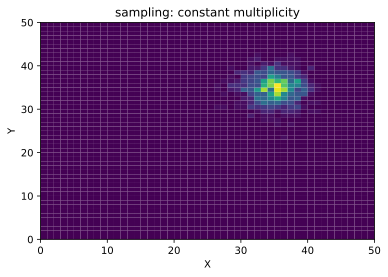

In [7]:
plot(particles=PARTICLES, params_space=PARAMS_SPACE)

## Analytic solution

Analytic solution is similar to 2D case, with the difference being that instead of shifting
regular normal distribution, 2D multivariate distribution is being shifted.

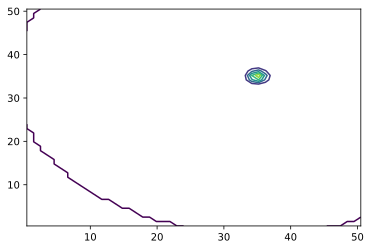

In [ ]:
def plot_analytic(*, params_space, params_p, params_t):
    """Plot the analytic solution of the advection equation."""

    # Adding half of space step ensures we descretize based on the center of the cell, instead
    # of the top left corner.
    x = np.linspace(0, params_space.span, params_space.n_cell) + params_space.step / 2
    y = np.linspace(0, params_space.span, params_space.n_cell) + params_space.step / 2

    x_mesh, y_mesh = np.meshgrid(x, y)
    pos = np.dstack((x_mesh, y_mesh))

    pdf = params_p.dist.pdf(pos - params_t.wind * params_t.span)

    pyplot.contour(x_mesh / params_space.step, y_mesh / params_space.step, pdf * params_space.step)
    show_plot()

plot_analytic(params_space=PARAMS_SPACE, params_p=PARAMS_P, params_t=PARAMS_T)

In [ ]:
def compute_rmse(*, particles, params_p, params_space, shift):
    """Compute rmse between current state of particles and analytical solution."""
    x = np.linspace(0, params_space.span, params_space.n_cell) + params_space.step / 2
    y = np.linspace(0, params_space.span, params_space.n_cell) + params_space.step / 2

    x_mesh, y_mesh = np.meshgrid(x, y)
    pos = np.dstack((x_mesh, y_mesh))

    pdf = params_p.dist.pdf(pos - shift)

    rmses = []

    for data in particles.values():
        histogram = np.histogram2d(
            data['cell'][:, 0],
            data['cell'][:, 1],
            bins=params_space.n_cell,
            range=[[0, params_space.n_cell], [0, params_space.n_cell]],
            weights=data['mult'] / params_p.norm
        )[0]

        rmse = np.sqrt(np.sum((pdf - histogram) ** 2) / params_space.n_cell ** 2)
        rmses.append(rmse)
    return rmses


compute_rmse(
    particles=PARTICLES,
    params_p=PARAMS_P,
    params_space=PARAMS_SPACE,
    shift=PARAMS_T.wind * PARAMS_T.span
)

[0.010544425110389864, 0.002285578066663851]

## Numerical vs. analytic solution

Comparison between numerical and analytic solution is conducted by calculating Root Mean
Squared Error (RMSE) at each timestep of advection simultion and plotting the results.

In [ ]:
def advect_compare(*, params_p, params_t, particles, rng, params_space):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift = abs(params_t.courant_number)
    assert probability_of_shift < 1

    rmses = []

    for step_idx in range(params_t.n_step):
        t = step_idx * params_t.step
        u01 = rng.uniform([0.0, 0.0], [1.0, 1.0], (params_p.n_part, 2))
        for particle in particles.values():
            particle['cell'] += np.array(probability_of_shift > u01, dtype=int)
        rmse = compute_rmse(
            particles=particles,
            params_p=params_p,
            params_space=params_space,
            shift=params_t.wind * t
        )
        rmses.append(rmse)
    return np.array(rmses)


PARTICLES = sample(params_p=PARAMS_P, params_space=PARAMS_SPACE, rng=RNG)
RMSES = advect_compare(
    particles=PARTICLES,
    params_t=PARAMS_T,
    params_p=PARAMS_P,
    params_space=PARAMS_SPACE,
    rng=RNG
)
print(RMSES)

array([[0.01268848, 0.00533618],
       [0.01198847, 0.00483266],
       [0.01081979, 0.00456318],
       [0.01064812, 0.00431836],
       [0.01152153, 0.00414265],
       [0.0115182 , 0.00396678],
       [0.01099588, 0.00377793],
       [0.0108136 , 0.00362928],
       [0.01165919, 0.00345784],
       [0.01175478, 0.00334057],
       [0.01164274, 0.00319126],
       [0.01070373, 0.00314841],
       [0.0107132 , 0.00308513],
       [0.01066819, 0.00303619],
       [0.01062696, 0.00294757],
       [0.01062923, 0.00287614],
       [0.01165375, 0.0028168 ],
       [0.01165358, 0.0027432 ],
       [0.01061812, 0.0027023 ],
       [0.01063719, 0.00264269],
       [0.01064751, 0.00256444],
       [0.01069898, 0.00253665],
       [0.01061939, 0.00252016],
       [0.0106272 , 0.00242202],
       [0.01062792, 0.0023618 ],
       [0.01062708, 0.0023574 ],
       [0.01062627, 0.00230322],
       [0.01067961, 0.00231062],
       [0.01110063, 0.00226205],
       [0.01061791, 0.00224424]])

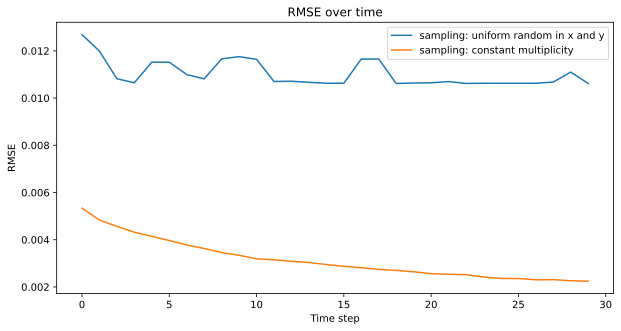

In [ ]:
def plot_rmses(*, rmses, params_t, particles):
    """Plot the RMSE over time."""
    x = list(range(params_t.n_step))
    pyplot.figure(figsize=(10, 5))
    for i, (title, _) in enumerate(particles.items()):
        pyplot.plot(x, rmses[:, i], label=title)
        pyplot.title('RMSE over time')
        pyplot.xlabel('Time step')
        pyplot.ylabel('RMSE')
        pyplot.legend()
    show_plot()

plot_rmses(rmses=RMSES, params_t=PARAMS_T, particles=PARTICLES)


## Conclusions

Achieved results indicate that Monte Carlo simulation of advection problem has been 
successfully generalized to two-dimensional space. From two sampling strategies that have been
employed, constant multiplicity sampling seems to be much more stable and achives much better
RMSE vs. analytic solution. 